In [23]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt

In [24]:

clusters_list = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)



In [25]:
# Test on the first 30 clusters
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
#clusters = clusters.head(50)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
94,5,25011,SRR5892449.10018,95
153,5,39243,SRR5892449.10138,154
458,2,14520,SRR5892449.10169,459
400,6,19525,SRR5892449.10199,401
380,2,8807,SRR5892449.10325,381


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

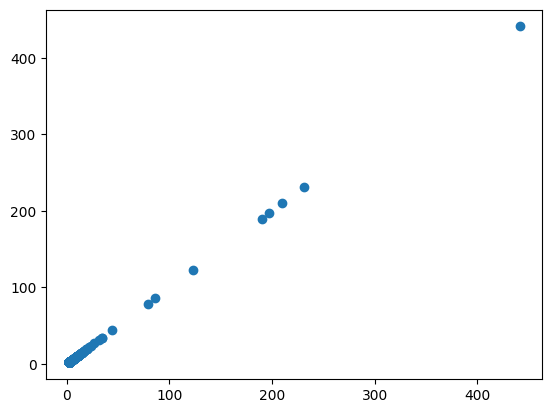

In [26]:
plt.scatter(x=clusters['coverage'], y=clusters['coverage'])

# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [27]:
from src.utils import get_sequences_by_id, convert_fq_to_fa, write_fasta
from src.kmer_cnt import count_kmer

In [28]:
#convert_fq_to_fa('test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fastq','test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fasta')

In [29]:
with open('test/s_cervisae_CEN.PK113-7D.fasta', 'r') as handle:
    s_cervisae = "".join(handle.read().splitlines()[1:-1])

In [30]:
fasta = 'test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [31]:
## Get the real mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [32]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.077405,0.066022,0.035572,0.046101,0.052647,0.037279,0.036141,0.034434,0.034434,0.022197,...,0.008822,0.017359,0.007684,0.047809,0.019351,0.029880,0.024189,0.011668,0.023620,SRR5892449.35847
1,0.098375,0.068039,0.032719,0.049621,0.051354,0.031419,0.033369,0.024702,0.030119,0.017335,...,0.009534,0.016901,0.008667,0.056121,0.017118,0.027086,0.023402,0.016035,0.022752,SRR5892449.35892
2,0.060823,0.045887,0.035281,0.040043,0.047619,0.031818,0.030952,0.036364,0.031169,0.027056,...,0.016017,0.019697,0.014719,0.045671,0.023377,0.029870,0.030303,0.023160,0.025541,SRR5892449.35465
3,0.069301,0.051975,0.033383,0.042256,0.056201,0.032749,0.036974,0.033594,0.029580,0.019015,...,0.012677,0.019649,0.024720,0.050285,0.015635,0.033805,0.034439,0.012888,0.025565,SRR5892449.33935
4,0.078598,0.057022,0.035831,0.041803,0.050279,0.036217,0.031786,0.029667,0.031786,0.029474,...,0.015604,0.018686,0.010981,0.046619,0.018494,0.030630,0.023117,0.015219,0.023887,SRR5892449.31135


# Dimensionality reduction with PCA and clustering with k-means 

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [34]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [35]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([9.84687986e-04, 6.36157511e-05])

In [36]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction)

## merging the dataframe with ids and other relevant information
kmer_reduction = pd.concat([kmer_reduction, hist_df['ids']], axis=1)
kmer_reduction.rename(columns={0:'comp1',1:'comp2'}, inplace=True)
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt']=(kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage']>10]
kmer_reduction.head()

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,mt
18,0.001429,0.016797,SRR5892449.28376,17,7306,2,1
61,0.250775,0.003276,SRR5892449.30216,12,10165,34,32
175,-0.008245,0.007643,SRR5892449.46683,12,13543,31,1
304,-0.008132,0.000567,SRR5892449.32857,32,16946,83,1
315,0.241449,0.006601,SRR5892449.57929,34,17159,45,32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

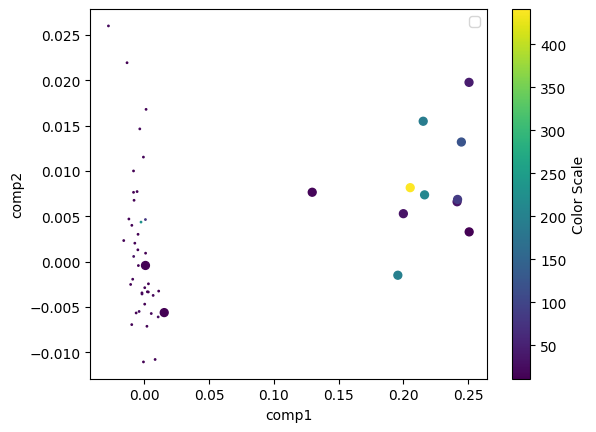

In [37]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [38]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.02043228198349355.
Iteration 1, inertia 0.018389700276181538.
Converged at iteration 1: strict convergence.


Text(0, 0.5, 'comp2')

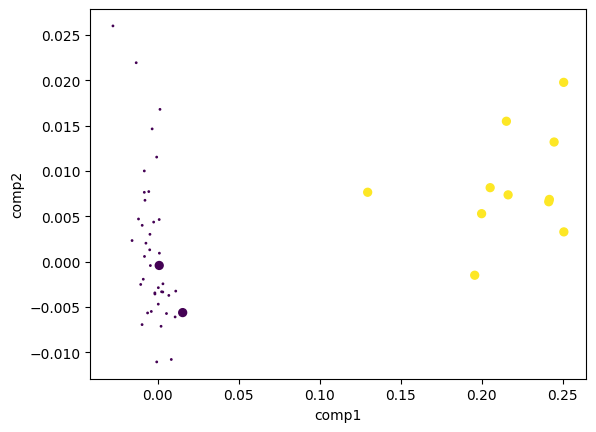

In [39]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [47]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].mean().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster['coverage'].sum()

1388

In [48]:
sequences_ids = list()
for i in selected_cluster['id_cluster']:
    sequences_ids.extend(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/mt_reads_v1.fasta')

TypeError: write_fasta() got an unexpected keyword argument 'sequences_ids'